# Imports

In [846]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rx
import jenkspy
from pysal.lib import weights
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp
import matplotlib

# Define country and parameters

In [847]:
# Select target country
country = 'Argentina'

# Set country-specific parameters: ISO codes and buffer size (in meters)
if country == 'Argentina':
    country_short = 'ARG'   # ISO 3-letter code
    country_code = 'AR'     # ISO 2-letter code
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
# Uncomment the following if Mexico is to be included in the analysis
# elif country == 'Mexico':
#     country_short = 'MEX'
#     country_code = 'MX'

# Set working directory

In [848]:
# Define working directory path
wd = (
#     '/your/path/to/working/directory/'
    '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/research/latin-mobility-covid'
)

# Load FB population baseline data at the resolution of FB mobility data

In [ ]:
# Load mobility cell baseline imputed population data from GeoPackage file
movcell_baseline_imput_pop = gpd.read_file(
    f"{wd}/data/outputs/{country_short}/grids-with-data/movcell-baseline-imput-pop/movcell-baseline-imput-pop.gpkg"
)

# Merge movcell baseline input pop with WP population via spatial join

In [ ]:
# This cell:
# - Loads WorldPop raster and converts it to a GeoDataFrame of points 
# - Performs a spatial join to assign population points to mobility grid cells and aggregates population within each cell
# - For Mexico, identifies a potential outlier in population values and smooths it by replacing with the spatial lag of its neighbours

# Import WorldPop raster and convert it to a GeoDataFrame of points at pixel centroids
rds = rx.open_rasterio(
    wd + f'/data/inputs/population/worldpop/{country_short.lower()}_ppp_2020_1km_Aggregated.tif'
)
rds.name = "population"

# Convert raster to DataFrame and create geometry from pixel centroids
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
gdf_worldpop = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

# Drop unnecessary columns
gdf_worldpop = gdf_worldpop.drop(['y', 'x', 'band', 'spatial_ref'], axis=1)

# Filter out invalid population values and reproject to WGS84
gdf_worldpop = gdf_worldpop[gdf_worldpop['population'] != -99999].reset_index(drop=True)
gdf_worldpop = gdf_worldpop.to_crs('EPSG:4326')

# Spatial join: assign WorldPop points to mobility cells with population data
grid_wp = gpd.sjoin(movcell_baseline_imput_pop, gdf_worldpop)

# Aggregate population within each mobility cell
grid_wp_group = grid_wp[['population']].groupby(grid_wp.index).sum()

# Merge aggregated WorldPop population data back into mobility cell GeoDataFrame
movcell_baseline_imput_pop = pd.merge(
    movcell_baseline_imput_pop,
    grid_wp_group,
    how='left',
    left_index=True,
    right_index=True
)

if country == 'Mexico':
    # Identify the second highest population cell (potentially an outlier)
    id_problem = movcell_baseline_imput_pop.sort_values(by='population', ascending=False).iloc[1].name

    # Create spatial weights matrix (Queen contiguity) for all mobility cells
    w = weights.Queen.from_dataframe(movcell_baseline_imput_pop)

    # Remove isolated cells (islands) from the dataset
    movcell_baseline_imput_pop_w = movcell_baseline_imput_pop.drop(w.islands)

    # Recalculate spatial weights matrix without islands
    w = weights.Queen.from_dataframe(movcell_baseline_imput_pop_w)
    w.transform = 'R'  # Row-standardize weights

    # Calculate spatial lag of population variable (weighted average of neighbors)
    movcell_baseline_imput_pop_w['population_lag'] = weights.lag_spatial(
        w, movcell_baseline_imput_pop_w['population']
    )

    # Replace the problematic population value with its spatial lag value
    movcell_baseline_imput_pop.loc[id_problem, 'population'] = (
        movcell_baseline_imput_pop_w.loc[id_problem, 'population_lag']
    )

# Quick check of results
# Plot scatter of WorldPop population vs. imputed population on weekday 5
fig, ax = plt.subplots()
ax.scatter(movcell_baseline_imput_pop['population'], movcell_baseline_imput_pop['5'], alpha=0.6)
ax.set_xlabel('WorldPop Population')
ax.set_ylabel('Imputed Population (Weekday 5)')
ax.set_title('Scatter plot: WorldPop vs Imputed Population (Weekday 5)')
plt.show()

# Classify mobility cells into population density categories

In [ ]:
# Number of density classes
n_class_density = 5

# Calculate population density (population per sq km) using area in EPSG:3857 projection
area_sqm = movcell_baseline_imput_pop['geometry'].to_crs('EPSG:3857').area
movcell_baseline_imput_pop['density'] = movcell_baseline_imput_pop['population'] / (area_sqm / 1e6)

# Compute Jenks natural breaks for density classification
breaks_density = jenkspy.jenks_breaks(
    movcell_baseline_imput_pop.dropna(subset=['density'])['density'],
    n_classes=n_class_density
)

# Slightly adjust lower bound to include minimum values
breaks_density[0] -= 1e-10

# Classify densities using Jenks breaks
movcell_baseline_imput_pop['class_density'] = pd.cut(
    movcell_baseline_imput_pop['density'],
    bins=breaks_density,
    labels=range(n_class_density),
    include_lowest=True
).astype(float)


# Map population density categories

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

if country != 'Mexico':
    background = gpd.read_file(
        wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp'
    ).to_crs('EPSG:4326')
else:
    background = gpd.read_file(
        wd + '/data/inputs/boundaries/central-america/bound_p.shp'
    ).to_crs('EPSG:4326')

background.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)

if country != 'Mexico':
    background[background['name'] == country.upper()].plot(ax=ax, color='None', zorder=2)
else:
    shape = gpd.read_file(
        wd + '/data/inputs/boundaries/gadm41_MEX_2.json'
    ).to_crs('EPSG:4326')
    shape.plot(ax=ax, color='None', zorder=2)

ax.set_facecolor('lightskyblue')

movcell_baseline_imput_pop.plot(
    column='density',
    cmap='viridis',
    legend=False,
    zorder=2,
    ax=ax
)

if country == 'Argentina' or country == 'Chile':
    ax.set_xlim(-77, -49)
    ax.set_ylim(-57, -16)
elif country == 'Colombia':
    ax.set_xlim(-80, -64)
    ax.set_ylim(-5.5, 13.5)
elif country == 'Mexico':
    ax.set_xlim(-119, -85)
    ax.set_ylim(10, 38)

ax.tick_params(
    axis='both',
    which='both',
    width=0,
    length=0,
    color='k',
    labelleft=False,
    labelbottom=False
)

labels_density = breaks_density    
custom_labels = []
for i in range(n_class_density - 1):
    custom_labels.append(f'[{int(labels_density[i])}, {int(labels_density[i+1])})')
custom_labels.append(f'[{int(labels_density[-2])}, {int(labels_density[-1])}]')

colors = mcp.gen_color(cmap='viridis', n=n_class_density)
legend_elements = [
    Line2D([0], [0], lw=0, color=colors[i], marker='o', markersize=10, label=custom_labels[i])
    for i in range(len(colors))
]

if country in ['Argentina', 'Chile', 'Colombia']:
    loc = 'lower right'
elif country == 'Mexico':
    loc = 'lower left'

# Uncomment to add legend and scalebar as needed
# legend = ax.legend(handles=legend_elements, handlelength=0, fontsize=14, shadow=False,
#                    fancybox=False, loc=loc, ncol=1, columnspacing=1.2,
#                    borderpad=1, title='Population density from \nWorldPop (persons/sqkm)')
# for t in legend.get_texts():
#     t.set_ha('right')
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_linewidth(1)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((1, 1, 1, 0.7))
# legend.get_title().set_fontsize('14')
# ax.add_artist(ScaleBar(dx=1, units="km", dimension="si-length", length_fraction=.1,
#                        scale_formatter=lambda value, unit: f' {value * 100} km ',
#                        pad=0.7, sep=5, border_pad=1, scale_loc='top',
#                        box_color='w', box_alpha=0, font_properties={'size':20}, location='upper left'))

# Uncomment to add north arrow image as needed
# im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')
# if country == 'Argentina':
#     loc_arr1 = [0.655, 0.82, 0.04, 0.04]
# elif country == 'Chile':
#     loc_arr1 = [0.655, 0.82, 0.04, 0.04]
# elif country == 'Colombia':
#     loc_arr1 = [0.755, 0.82, 0.04, 0.04]
# elif country == 'Mexico':
#     loc_arr1 = [0.83, 0.78, 0.04, 0.04]
# newax = fig.add_axes(loc_arr1, zorder=1)
# newax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, width=0, length=0)
# newax.set_facecolor('None')
# plt.setp(newax.spines.values(), linewidth=0)
# newax.imshow(im)

# plt.savefig(wd + '/plots/map-classes/map-classes-density-' + country_short + '-nolegend.pdf', bbox_inches='tight')

plt.show()


# Merge movcell baseline input pop with level of Relative Deprivation

In [ ]:
# Only uncomment if you want to reread the RDI raster and generate a GeoPackage with point geometries
# Import RDI raster and convert it to a GeoDataFrame of points at pixel centroids

file_raster = wd + '/data/inputs/rdi/povmap-grdi-v1-grdiv1-geotiff/povmap-grdi-v1.tif'

# Open the raster file using rioxarray
rds = rx.open_rasterio(file_raster)
rds.name = "rdi"

# Convert raster to DataFrame, squeezing to remove single-dimensional entries and resetting the index
df_rdi = rds.squeeze().to_dataframe().reset_index()

# Filter out invalid RDI values (keep only rdi >= 0)
df_rdi = df_rdi[df_rdi['rdi'] >= 0].reset_index(drop=True)

# Create point geometries from raster pixel centroids using x and y coordinates
geometry = gpd.points_from_xy(df_rdi.x, df_rdi.y)

# Create GeoDataFrame with the same CRS as the raster
gdf_rdi = gpd.GeoDataFrame(df_rdi, crs=rds.rio.crs, geometry=geometry)

# Drop unnecessary columns related to raster metadata
gdf_rdi = gdf_rdi.drop(['y', 'x', 'band', 'spatial_ref'], axis=1)

# Reproject GeoDataFrame to WGS84 (EPSG:4326)
gdf_rdi = gdf_rdi.to_crs('epsg:4326')

# Spatially join RDI points to mobility cells to assign RDI values to each cell
grid_rdi_join = gpd.sjoin(movcell_baseline_imput_pop, gdf_rdi)

# Drop rows where RDI values are missing (NaN)
grid_rdi_join = grid_rdi_join.dropna(subset=['rdi'])

# Calculate mean RDI value per mobility cell (grouped by cell index)
grid_rdi_group = grid_rdi_join[['rdi']].groupby(grid_rdi_join.index).mean()

# Merge the aggregated mean RDI values back into the mobility cells GeoDataFrame
movcell_baseline_imput_pop = pd.merge(
    movcell_baseline_imput_pop, 
    grid_rdi_group, 
    how='left', 
    left_index=True, 
    right_index=True
)


# Classify mobility cells into RDI categories

In [ ]:
n_class_rdi = 3

# Calculate Jenks natural breaks for RDI values, ignoring NaNs
breaks_rdi = jenkspy.jenks_breaks(
    movcell_baseline_imput_pop.dropna(subset=['rdi'])['rdi'], 
    n_classes=n_class_rdi
)

# Slightly lower the first break to include minimum value
breaks_rdi[0] = breaks_rdi[0] - 10**(-10)

# Classify RDI values into bins based on Jenks breaks with labels 0, 1, 2
movcell_baseline_imput_pop['class_rdi'] = pd.cut(
    movcell_baseline_imput_pop['rdi'], 
    bins=breaks_rdi, 
    labels=[i for i in range(n_class_rdi)]
)

# Convert class labels from categorical to numeric type
movcell_baseline_imput_pop['class_rdi'] = pd.to_numeric(movcell_baseline_imput_pop['class_rdi'])


# Map RDI categories

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

if country != 'Mexico':
    background = gpd.read_file(wd + '/data/inputs/boundaries/south-america/vc965bq8111.shp').to_crs('EPSG:4326')
else:
    background = gpd.read_file(wd + '/data/inputs/boundaries/central-america/bound_p.shp').to_crs('EPSG:4326')

background.plot(ax=ax, facecolor='dimgray', alpha=0.5, zorder=1)
if country != 'Mexico':
    background[background['name'] == country.upper()].plot(ax=ax, color='None', zorder=2)
else:
    shape = gpd.read_file(wd + '/data/inputs/boundaries/gadm41_MEX_2.json').to_crs('EPSG:4326')
    shape.plot(ax=ax, color='None', zorder=2)

ax.set_facecolor('lightskyblue')

movcell_baseline_imput_pop['class_rdi_plot'] = movcell_baseline_imput_pop['class_rdi']
for i in range(len(movcell_baseline_imput_pop)):
    if pd.isna(movcell_baseline_imput_pop.loc[i, 'class_rdi_plot']):
        movcell_baseline_imput_pop.loc[i, 'class_rdi_plot'] = 2
        
        
# get the base colormap
cmap_base = matplotlib.colormaps.get_cmap('inferno')
# sample 27 evenly spaced colors from it
cmap = [cmap_base(i / 26) for i in [4, 13, 23]]  # picks mid-range colors
movcell_baseline_imput_pop.plot(
    column='class_rdi_plot',
    cmap=matplotlib.colors.ListedColormap(cmap),
    k=3,
    legend=False,
    zorder=2,
    ax=ax
)
movcell_baseline_imput_pop.drop(['class_rdi_plot'], axis=1)

movcell_baseline_imput_pop.plot(column='class_rdi', cmap='inferno', ax=ax, legend=False)

if country == 'Argentina':
    ax.set_xlim(-77, -49)
    ax.set_ylim(-57, -16)
elif country == 'Chile':
    ax.set_xlim(-77, -49)
    ax.set_ylim(-57, -16)
elif country == 'Colombia':
    ax.set_xlim(-80, -64)
    ax.set_ylim(-5.5, 13.5)
elif country == 'Mexico':
    ax.set_xlim(-119, -85)
    ax.set_ylim(10, 38)

ax.tick_params(axis='both', which='both', width=0, length=0, color='k', labelleft=False, labelbottom=False)

im = plt.imread(wd + '/data/inputs/boundaries/north-arrow.png')

if country == 'Argentina':
    loc_arr1 = [0.655, 0.82, 0.04, 0.04]
elif country == 'Chile':
    loc_arr1 = [0.655, 0.82, 0.04, 0.04]
elif country == 'Colombia':
    loc_arr1 = [0.755, 0.82, 0.04, 0.04]
elif country == 'Mexico':
    loc_arr1 = [0.83, 0.78, 0.04, 0.04]

newax = fig.add_axes(loc_arr1, zorder=1)
newax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, width=0, length=0)
newax.set_facecolor('None')
plt.setp(newax.spines.values(), linewidth=0)
# newax.imshow(im)

# plt.savefig(
#     wd + '/plots/map-classes/map-classes-rdi-' + country_short + '-nolegend-invert-new-palette.pdf',
#     bbox_inches='tight'
# )

plt.show()


# Merge movcell baseline impute pop with population 2 from worldpop

This population database is also from Worlpop, same year, but global. Better to use this one to compute percentage of old and young population, because the Worlpop Population data by country has a few values that lead to dependency ratios >1! Although, for Chile we still find the same problem and actually the country-specific pop file gives a better result.

In [ ]:
# Only uncomment if you want to reread the RDI raster and generate a GeoPackage with point geometries
# Import RDI raster and convert it to a GeoDataFrame of points at pixel centroids

file_raster2 = wd + '/data/inputs/population/worldpop/ppp_2020_1km_Aggregated.tif'

# Open the raster file using rioxarray
rds2 = rx.open_rasterio(file_raster2)
rds2.name = "pop2"

# Convert raster to DataFrame, squeezing to remove single-dimensional entries and resetting the index
df_pop2 = rds2.squeeze().to_dataframe().reset_index()

# Filter out invalid values (keep only >= 0)
df_pop2 = df_pop2[df_pop2['pop2'] >= 0].reset_index(drop=True)

df_pop2 = df_pop2[df_pop2['x'] >= minx-1].reset_index(drop=True)
df_pop2 = df_pop2[df_pop2['x'] <= maxx+1].reset_index(drop=True)
df_pop2 = df_pop2[df_pop2['y'] >= miny-1].reset_index(drop=True)
df_pop2 = df_pop2[df_pop2['y'] <= maxy+1].reset_index(drop=True)

# Create point geometries from raster pixel centroids using x and y coordinates
geometry = gpd.points_from_xy(df_pop2.x, df_pop2.y)

# Create GeoDataFrame with the same CRS as the raster
gdf_pop2 = gpd.GeoDataFrame(df_pop2, crs=rds.rio.crs, geometry=geometry)

# Drop unnecessary columns related to raster metadata
gdf_pop2 = gdf_pop2.drop(['y', 'x', 'band', 'spatial_ref'], axis=1)

# Reproject GeoDataFrame to WGS84 (EPSG:4326)
gdf_pop2 = gdf_pop2.to_crs('epsg:4326')

# Spatially join old points to mobility cells to assign old values to each cell
grid_pop2_join = gpd.sjoin(movcell_baseline_imput_pop, gdf_pop2)

# Drop rows where old values are missing (NaN)
grid_pop2_join = grid_pop2_join.dropna(subset=['pop2'])

# Calculate sum old value per mobility cell (grouped by cell index)
grid_pop2_group = grid_pop2_join[['pop2']].groupby(grid_pop2_join.index).sum()

# Merge the aggregated mean old values back into the mobility cells GeoDataFrame
movcell_baseline_imput_pop = pd.merge(
    movcell_baseline_imput_pop, 
    grid_pop2_group, 
    how='left', 
    left_index=True, 
    right_index=True
)

# Merge movcell baseline input pop with percentage of old population

In [ ]:
# Only uncomment if you want to reread the RDI raster and generate a GeoPackage with point geometries
# Import RDI raster and convert it to a GeoDataFrame of points at pixel centroids

file_raster = wd + '/data/inputs/population/worldpop/old_total_2020.tif'

# Open the raster file using rioxarray
rds = rx.open_rasterio(file_raster)
rds.name = "old"

# Convert raster to DataFrame, squeezing to remove single-dimensional entries and resetting the index
df_old = rds.squeeze().to_dataframe().reset_index()

minx, miny, maxx, maxy = movcell_baseline_imput_pop.total_bounds

# Filter out invalid values (keep only >= 0)
df_old = df_old[df_old['old'] >= 0].reset_index(drop=True)

df_old = df_old[df_old['x'] >= minx-1].reset_index(drop=True)
df_old = df_old[df_old['x'] <= maxx+1].reset_index(drop=True)
df_old = df_old[df_old['y'] >= miny-1].reset_index(drop=True)
df_old = df_old[df_old['y'] <= maxy+1].reset_index(drop=True)

# Create point geometries from raster pixel centroids using x and y coordinates
geometry = gpd.points_from_xy(df_old.x, df_old.y)

# Create GeoDataFrame with the same CRS as the raster
gdf_old = gpd.GeoDataFrame(df_old, crs=rds.rio.crs, geometry=geometry)

# Drop unnecessary columns related to raster metadata
gdf_old = gdf_old.drop(['y', 'x', 'band', 'spatial_ref'], axis=1)

# Reproject GeoDataFrame to WGS84 (EPSG:4326)
gdf_old = gdf_old.to_crs('epsg:4326')

# Spatially join old points to mobility cells to assign old values to each cell
grid_old_join = gpd.sjoin(movcell_baseline_imput_pop, gdf_old)

# Drop rows where old values are missing (NaN)
grid_old_join = grid_old_join.dropna(subset=['old'])

# Calculate sum old value per mobility cell (grouped by cell index)
grid_old_group = grid_old_join[['old']].groupby(grid_old_join.index).sum()

# Merge the aggregated mean old values back into the mobility cells GeoDataFrame
movcell_baseline_imput_pop = pd.merge(
    movcell_baseline_imput_pop, 
    grid_old_group, 
    how='left', 
    left_index=True, 
    right_index=True
)


In [ ]:
movcell_baseline_imput_pop['per_old'] = [movcell_baseline_imput_pop.loc[i, 'old']/movcell_baseline_imput_pop.loc[i, 'population']*100 for i in range(len(movcell_baseline_imput_pop))]
movcell_baseline_imput_pop['per_old2'] = [movcell_baseline_imput_pop.loc[i, 'old']/movcell_baseline_imput_pop.loc[i, 'pop2']*100 for i in range(len(movcell_baseline_imput_pop))]


# Merge movcell baseline input pop with percentage of young population

In [ ]:
# Only uncomment if you want to reread the RDI raster and generate a GeoPackage with point geometries
# Import RDI raster and convert it to a GeoDataFrame of points at pixel centroids

file_raster = wd + '/data/inputs/population/worldpop/young_total_2020.tif'

# Open the raster file using rioxarray
rds = rx.open_rasterio(file_raster)
rds.name = "young"

# Convert raster to DataFrame, squeezing to remove single-dimensional entries and resetting the index
df_young = rds.squeeze().to_dataframe().reset_index()

minx, miny, maxx, maxy = movcell_baseline_imput_pop.total_bounds

# Filter out invalid values (keep only >= 0)
df_young = df_young[df_young['young'] >= 0].reset_index(drop=True)

df_young = df_young[df_young['x'] >= minx-1].reset_index(drop=True)
df_young = df_young[df_young['x'] <= maxx+1].reset_index(drop=True)
df_young = df_young[df_young['y'] >= miny-1].reset_index(drop=True)
df_young = df_young[df_young['y'] <= maxy+1].reset_index(drop=True)

# Create point geometries from raster pixel centroids using x and y coordinates
geometry = gpd.points_from_xy(df_young.x, df_young.y)

# Create GeoDataFrame with the same CRS as the raster
gdf_young = gpd.GeoDataFrame(df_young, crs=rds.rio.crs, geometry=geometry)

# Drop unnecessary columns related to raster metadata
gdf_young = gdf_young.drop(['y', 'x', 'band', 'spatial_ref'], axis=1)

# Reproject GeoDataFrame to WGS84 (EPSG:4326)
gdf_young = gdf_young.to_crs('epsg:4326')

# Spatially join old points to mobility cells to assign old values to each cell
grid_young_join = gpd.sjoin(movcell_baseline_imput_pop, gdf_young)

# Drop rows where old values are missing (NaN)
grid_young_join = grid_young_join.dropna(subset=['young'])

# Calculate sum old value per mobility cell (grouped by cell index)
grid_young_group = grid_young_join[['young']].groupby(grid_young_join.index).sum()

# Merge the aggregated mean old values back into the mobility cells GeoDataFrame
movcell_baseline_imput_pop = pd.merge(
    movcell_baseline_imput_pop, 
    grid_young_group, 
    how='left', 
    left_index=True, 
    right_index=True
)


In [ ]:
movcell_baseline_imput_pop['per_young'] = [movcell_baseline_imput_pop.loc[i, 'young']/movcell_baseline_imput_pop.loc[i, 'population']*100 for i in range(len(movcell_baseline_imput_pop))]
movcell_baseline_imput_pop['per_young2'] = [movcell_baseline_imput_pop.loc[i, 'young']/movcell_baseline_imput_pop.loc[i, 'pop2']*100 for i in range(len(movcell_baseline_imput_pop))]


In [ ]:
index_odd_old = []
for i in range(len(movcell_baseline_imput_pop)):
    if movcell_baseline_imput_pop.loc[i, 'per_old'] > 100:
        index_odd_old.append(i)

index_odd_old2 = []
for i in range(len(movcell_baseline_imput_pop)):
    if movcell_baseline_imput_pop.loc[i, 'per_old2'] > 100:
        index_odd_old2.append(i)
        
index_odd_young = []
for i in range(len(movcell_baseline_imput_pop)):
    if movcell_baseline_imput_pop.loc[i, 'per_young'] > 100:
        index_odd_young.append(i)

index_odd_young2 = []
for i in range(len(movcell_baseline_imput_pop)):
    if movcell_baseline_imput_pop.loc[i, 'per_young2'] > 100:
        index_odd_young2.append(i)
        
print(len(index_odd_old), len(index_odd_old2), len(index_odd_young), len(index_odd_young2))

# Assign Combined Class Labels Based on Density and RDI Categories

In [ ]:
# Initialise counter for total number of combined classes
n_class = 0
# Dictionary to store combined class labels as keys with [density_class, rdi_class] pairs as values
n_class_labels = {}

# Loop over all density classes and RDI classes to create combined class label pairs
for i in range(n_class_density):
    for j in range(n_class_rdi):
        n_class += 1
        n_class_labels[n_class - 1] = [i, j]

# Print all combined class labels with their corresponding pairs
print(n_class_labels)

# Initialise a new column in the DataFrame to hold combined class labels (default to 0)
movcell_baseline_imput_pop['n_class_label'] = np.zeros(len(movcell_baseline_imput_pop))

# Assign combined class label for each row based on matching density and RDI classes
for i in range(len(movcell_baseline_imput_pop)):
    # Extract the density and RDI class for the current row
    pair = [
        movcell_baseline_imput_pop.loc[i, 'class_density'],
        movcell_baseline_imput_pop.loc[i, 'class_rdi']
    ]
    # Find the combined class key that matches the current [density, rdi] pair
    matching_keys = [key for key, value in n_class_labels.items() if value == pair]

    # If no matching combined class found, assign NaN
    if len(matching_keys) == 0:
        movcell_baseline_imput_pop.loc[i, 'n_class_label'] = np.nan
    else:
        # Otherwise, assign the combined class label
        movcell_baseline_imput_pop.loc[i, 'n_class_label'] = matching_keys[0]

        
# movcell_baseline_imput_pop.to_file(
#     wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/movcell-baseline-imput-pop-with-exo-var.gpkg'
# )


# Percentage population in each category

In [1308]:
country= 'Colombia'
country_short = 'COL'
movcell_baseline_imput_pop = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/movcell-baseline-imput-pop-with-exo-var.gpkg')


In [1309]:
popcell_baseline_raw_pop = pd.read_csv(wd + '/data/outputs/' + country_short + '/baseline/baseline_pop.csv')

popcell_baseline_raw_pop = popcell_baseline_raw_pop.replace(-999, np.nan)
popcell_baseline_raw_pop = popcell_baseline_raw_pop.reset_index(drop=True)

lookup = gpd.read_file(wd + '/data/inputs/grids/Grid_' + country + '_lookup_mov_to_pop.gpkg')
lookup = lookup[['FID_mov', 'FID_pop']]

popcell_baseline_raw_pop = popcell_baseline_raw_pop.merge(lookup, left_on="FID", right_on="FID_pop")
popcell_baseline_raw_pop = popcell_baseline_raw_pop.drop(['FID'], axis=1)


In [1310]:
movcell_baseline_impute_pop_class = movcell_baseline_imput_pop[['population', 'density', 'rdi']]

popcell_baseline_raw_pop_merge = popcell_baseline_raw_pop.merge(movcell_baseline_impute_pop_class,
                                                          left_on="FID_mov",
                                                          right_on=movcell_baseline_impute_pop_class.index)

In [1311]:
grouped = (
    popcell_baseline_raw_pop_merge
    .groupby("FID_mov", as_index=False)
    .agg(lambda x: x.mean(skipna=False))
)

popcell_baseline_raw_pop_merge = grouped

In [1312]:
cols = [str(i) for i in range(7)]

print(len(popcell_baseline_raw_pop_merge))
popcell_baseline_raw_pop_merge = popcell_baseline_raw_pop_merge[
    (popcell_baseline_raw_pop_merge[cols] > 0).all(axis=1)
].reset_index(drop=True)
print(len(popcell_baseline_raw_pop_merge))

print(len(movcell_baseline_imput_pop))
movcell_baseline_imput_pop = movcell_baseline_imput_pop[
    (movcell_baseline_imput_pop[cols] > 0).all(axis=1)
].reset_index(drop=True)
print(len(movcell_baseline_imput_pop))

47897
9329
49324
47879


In [1313]:
# Calculate the average weekly value for each row across the first 7 columns (index 0 to 6)
average_week = []
average_week_raw = []

for i in range(len(movcell_baseline_imput_pop)):
    average_week.append(np.mean(movcell_baseline_imput_pop.loc[i, ['0', '1', '2', '3', '4', '5', '6']]))
    
for i in range(len(popcell_baseline_raw_pop_merge)):
    average_week_raw.append(np.mean(popcell_baseline_raw_pop_merge.loc[i, ['0', '1', '2', '3', '4', '5', '6']]))

# Add the average weekly values as a new column
movcell_baseline_imput_pop['average_week'] = average_week
popcell_baseline_raw_pop_merge['average_week'] = average_week_raw

In [1314]:
# Number of density classes
n_class_density = 5

# Compute Jenks natural breaks for density classification
breaks_density = jenkspy.jenks_breaks(
    popcell_baseline_raw_pop_merge.dropna(subset=['density'])['density'],
    n_classes=n_class_density
)

# Slightly adjust lower bound to include minimum values
breaks_density[0] -= 1e-10

# Classify densities using Jenks breaks
popcell_baseline_raw_pop_merge['class_density'] = pd.cut(
    popcell_baseline_raw_pop_merge['density'],
    bins=breaks_density,
    labels=range(n_class_density),
    include_lowest=True
).astype(float)


n_class_rdi = 3

# Compute Jenks natural breaks for density classification
breaks_rdi = jenkspy.jenks_breaks(
    popcell_baseline_raw_pop_merge.dropna(subset=['rdi'])['rdi'],
    n_classes=n_class_rdi
)

# Slightly adjust lower bound to include minimum values
breaks_rdi[0] -= 1e-10

# Classify densities using Jenks breaks
popcell_baseline_raw_pop_merge['class_rdi'] = pd.cut(
    popcell_baseline_raw_pop_merge['rdi'],
    bins=breaks_rdi,
    labels=range(n_class_rdi),
    include_lowest=True
).astype(float)


In [1315]:
# Initialise lists to store total Facebook and WorldPop populations per density class
fb_pop_class_density = []
fb_pop_raw_class_density = []
wp_pop_class_density = []

# Sum the 'average_week' and 'population' values for each density class
n_class_density = 5
for i in range(n_class_density):
    fb_pop_class_density.append(
        np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density'] == i]['average_week'])
    )
    fb_pop_raw_class_density.append(
        np.sum(popcell_baseline_raw_pop_merge[popcell_baseline_raw_pop_merge['class_density'] == i]['average_week'])
    )
    wp_pop_class_density.append(
        np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density'] == i]['population'])
    )

# Calculate the percentage distribution of Facebook and WorldPop populations by density class
fb_pop_class_density_per = fb_pop_class_density / np.sum(fb_pop_class_density) * 100
fb_pop_raw_class_density_per = fb_pop_raw_class_density / np.sum(fb_pop_raw_class_density) * 100
wp_pop_class_density_per = wp_pop_class_density / np.sum(wp_pop_class_density) * 100

# Initialise lists to store total Facebook and WorldPop populations per RDI class
fb_pop_class_rdi = []
fb_pop_raw_class_rdi = []
wp_pop_class_rdi = []

# Sum the 'average_week' and 'population' values for each RDI class
n_class_rdi = 3
for i in range(n_class_rdi):
    fb_pop_class_rdi.append(
        np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_rdi'] == i]['average_week'])
    )
    fb_pop_raw_class_rdi.append(
        np.sum(popcell_baseline_raw_pop_merge[popcell_baseline_raw_pop_merge['class_rdi'] == i]['average_week'])
    )
    wp_pop_class_rdi.append(
        np.sum(movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_rdi'] == i]['population'])
    )

# Calculate the percentage distribution of Facebook and WorldPop populations by RDI class
fb_pop_class_rdi_per = fb_pop_class_rdi / np.sum(fb_pop_class_rdi) * 100
fb_pop_raw_class_rdi_per = fb_pop_raw_class_rdi / np.sum(fb_pop_raw_class_rdi) * 100
wp_pop_class_rdi_per = wp_pop_class_rdi / np.sum(wp_pop_class_rdi) * 100

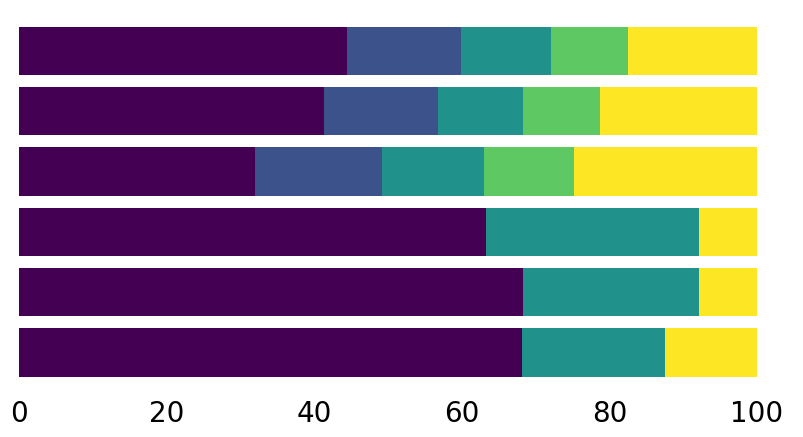

In [1316]:
# Plot to see distribution of population in each category
fig, ax = plt.subplots(figsize=(10, 5))



fb_pop_raw_class_density_lim = [np.sum(fb_pop_raw_class_density_per[0:i]) for i in range(len(fb_pop_raw_class_density_per))]
ax.barh(4, width=fb_pop_raw_class_density_per, left=fb_pop_raw_class_density_lim, color=mcp.gen_color(cmap='viridis', n=n_class_density))

fb_pop_class_density_lim = [np.sum(fb_pop_class_density_per[0:i]) for i in range(len(fb_pop_class_density_per))]
ax.barh(5, width=fb_pop_class_density_per, left=fb_pop_class_density_lim, color=mcp.gen_color(cmap='viridis', n=n_class_density))

wp_pop_class_density_lim = [np.sum(wp_pop_class_density_per[0:i]) for i in range(len(wp_pop_class_density_per))]
ax.barh(6, width=wp_pop_class_density_per, left=wp_pop_class_density_lim, color=mcp.gen_color(cmap='viridis', n=n_class_density))



fb_pop_raw_class_rdi_lim = [np.sum(fb_pop_raw_class_rdi_per[0:i]) for i in range(len(fb_pop_raw_class_rdi_per))]
ax.barh(1, width=fb_pop_raw_class_rdi_per, left=fb_pop_raw_class_rdi_lim, color=mcp.gen_color(cmap='viridis', n=n_class_rdi))

fb_pop_class_rdi_lim = [np.sum(fb_pop_class_rdi_per[0:i]) for i in range(len(fb_pop_class_rdi_per))]
ax.barh(2, width=fb_pop_class_rdi_per, left=fb_pop_class_rdi_lim, color=mcp.gen_color(cmap='viridis', n=n_class_rdi))

wp_pop_class_rdi_lim = [np.sum(wp_pop_class_rdi_per[0:i]) for i in range(len(wp_pop_class_rdi_per))]
ax.barh(3, width=wp_pop_class_rdi_per, left=wp_pop_class_rdi_lim, color=mcp.gen_color(cmap='viridis', n=n_class_rdi))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis='both', rotation=0, length=0, labelsize=20, labelleft=False, labelbottom=True)

# plt.savefig(wd + '/plots/percentage-classes/percentage-classes-' + country_short + '.pdf', bbox_inches='tight')


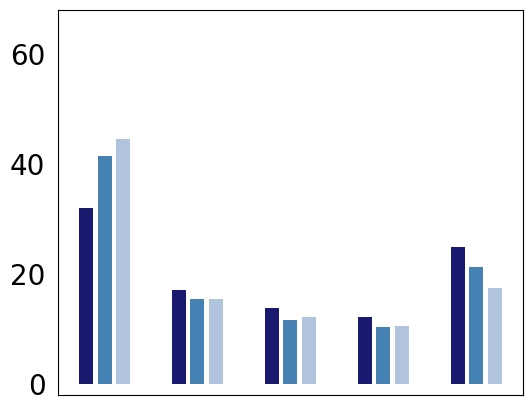

In [1317]:
# Plot to see distribution of population in each category
fig, ax = plt.subplots(figsize=(6, 5))

x = np.arange(len(fb_pop_class_density_per))


ax.bar(x-0.2, fb_pop_raw_class_density_per, width=0.15, color='midnightblue', align='center')
ax.bar(x, fb_pop_class_density_per, width=0.15, color='steelblue', align='center')
ax.bar(x+0.2, wp_pop_class_density_per, width=0.15, color='lightsteelblue', align='center')

ax.set_ylim([-2,68]) 

ax.tick_params(axis='both', which='both', labelbottom=False, width=0, length=0, color='k', labelsize=20, pad=9)

# plt.savefig(wd + '/plots/percentage-classes/percentage-classes-' + country_short + '-double-bars-density-r1.pdf', bbox_inches='tight')

plt.show()

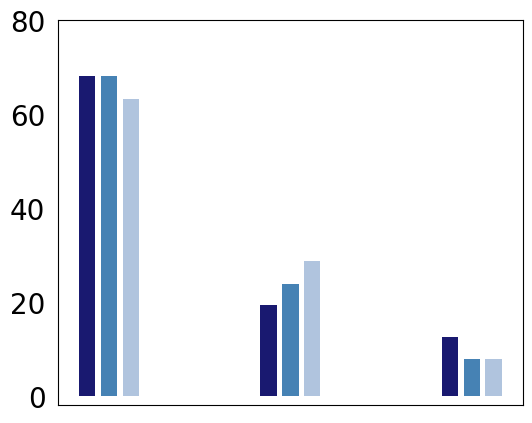

In [1318]:
# Plot to see distribution of population in each category
fig, ax = plt.subplots(figsize=(6, 5))

x = np.array([0,1,2])

ax.bar(x-0.12, fb_pop_raw_class_rdi_per, width=0.09, color='midnightblue', align='center')
ax.bar(x, fb_pop_class_rdi_per, width=0.09, color='steelblue', align='center')
ax.bar(x+0.12, wp_pop_class_rdi_per, width=0.09, color='lightsteelblue', align='center')

ax.set_ylim([-2,80]) 

ax.tick_params(axis='both', which='both', labelbottom=False, width=0, length=0, color='k', labelsize=20, pad=9)

# plt.savefig(wd + '/plots/percentage-classes/percentage-classes-' + country_short + '-double-bars-rdi-r1.pdf', bbox_inches='tight')

plt.show()

# Average old-age dependency ratio in each category

In [ ]:
country= 'Chile'
country_short = 'CHL'
movcell_baseline_imput_pop = gpd.read_file(wd + '/data/outputs/' + country_short + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/movcell-baseline-imput-pop-with-exo-var.gpkg')


In [ ]:
movcell_baseline_imput_pop = movcell_baseline_imput_pop[movcell_baseline_imput_pop['per_old2']<30].reset_index(drop=True)


In [ ]:
plt.scatter(movcell_baseline_imput_pop['density'], movcell_baseline_imput_pop['per_old2'])


In [ ]:
plt.scatter(movcell_baseline_imput_pop['class_density'], movcell_baseline_imput_pop['per_old2'])


In [ ]:
per_old_cat_density = []
for i in range(5):
    movcell_baseline_imput_pop_cat = movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_density']==i].reset_index(drop=True)
#     per_old_cat_density.append((np.sum(movcell_baseline_imput_pop_cat['old']))/
#                                (np.sum(movcell_baseline_imput_pop_cat['population']))*100)
    per_old_cat_density.append(np.mean(movcell_baseline_imput_pop_cat['per_old']))
per_old_cat_density = pd.DataFrame({'per_old': per_old_cat_density})
    
per_old_cat_density.to_csv(wd + '/data/inputs/population/worldpop/old-age-dependency/' + country_short + '/per_old_cat_density.csv')
    
per_old_cat_rdi = []
for i in range(3):
    movcell_baseline_imput_pop_cat = movcell_baseline_imput_pop[movcell_baseline_imput_pop['class_rdi']==i].reset_index(drop=True)
    per_old_cat_rdi.append(np.mean(movcell_baseline_imput_pop_cat['per_old']))
per_old_cat_rdi = pd.DataFrame({'per_old': per_old_cat_rdi})    
    
per_old_cat_rdi.to_csv(wd + '/data/inputs/population/worldpop/old-age-dependency/' + country_short + '/per_old_cat_rdi.csv')


In [ ]:
per_old_cat_density


In [ ]:
per_old_cat_rdi
